# Issues with Sliver Elimination

## Background

While investigating geometry problems in the OSGIS build process an issue was discovered with our sliver elimination logic that is causing issues with the overlay process. It was found that the current sliver elimination process is creating unwanted vertices in our geometries, and in some cases these vertices are at locations that can trigger errors in the sublot cutting process.

### Side Note: What Makes a Bad Vertex

When performing operations that compare geometries to one another, the Models API analyzes the vertices of each geometry and attempts to resolve any topology issues between them before performing the operation. In most cases, this insures that the outputs of the geometric operation are correct and do not have problems that can result from poor topology. However, when polygons have vertices that are very close to one another, it makes mitigating topology issues difficult.  

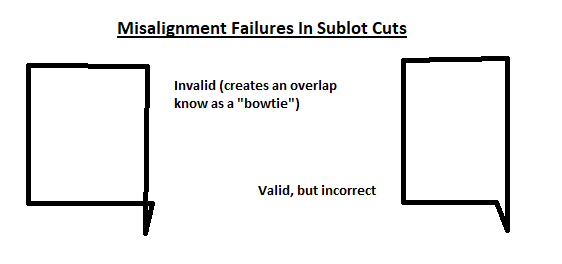

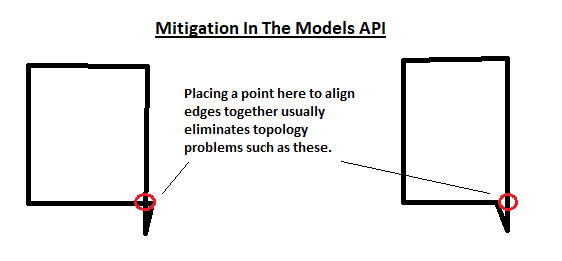

## Original Sliver Logic

The example below demonstrates the basic logic of the original sliver elimination process.

### Sample Inputs

Text(0.5, 1.0, 'Parcel and overlay geometries')

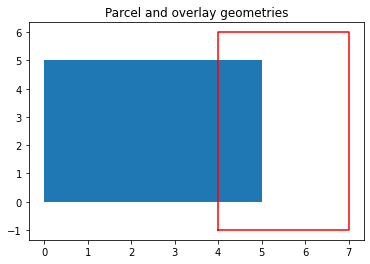

In [1]:
# import the required libraries
from envelopegis.models.polygon import Polygon
from envelopegis.models.point import Point

# for our example we will create two polygons,
# one representing a lot and one representing
# an overlay geometry which will result in a sliver

parcel_points = [
    {'x': 0, 'y': 0},
    {'x': 5, 'y': 0},
    {'x': 5, 'y': 5},
    {'x': 0, 'y': 5},
    {'x': 0, 'y': 0},
]
parcel_poly = Polygon(parcel_points, 2263)

overlay_points = [
    {'x': 4, 'y': -1},
    {'x': 7, 'y': -1},
    {'x': 7, 'y': 6},
    {'x': 4, 'y': 6},
    {'x': 4, 'y': -1},
]
overlay_poly = Polygon(overlay_points, 2263)

# plot our inputs
ax = parcel_poly.plot()
overlay_boundary = overlay_poly.boundary()
overlay_boundary.plot(ax=ax, color='red')
ax.set_title('Parcel and overlay geometries')

### Creating Sublots

The sublot creation process involves finding the intersection and difference between the parcel and overlay geometries.

Text(0.5, 1.0, 'Sublot and Sliver Polygons')

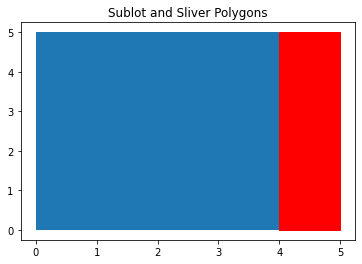

In [2]:
# divide the parcel poly into sublots
sliver_poly = parcel_poly.intersection(overlay_poly)
sublot_poly = parcel_poly.difference(overlay_poly)

# plot the sublots
ax = sublot_poly.plot()
sliver_poly.plot(ax=ax, color='red')
ax.set_title('Sublot and Sliver Polygons')

### Eliminating the Sliver

The sliver is eliminated by merging the sliver polygon back into the sublot polygon to return the geometry to _what looks like_ its original form.

Text(0.5, 1.0, 'Restored parcel (sliver eliminated)')

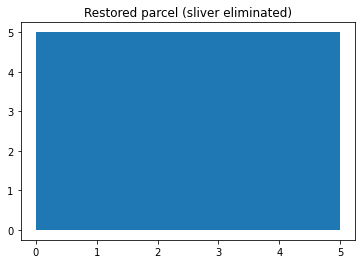

In [3]:
# merge the sublot and sliver polygons together
# using the union function
restored_parcel_poly = sublot_poly.union(sliver_poly)

# plot the restored parcel
ax = restored_parcel_poly.plot()
ax.set_title('Restored parcel (sliver eliminated)')

### But here's the rub....

When the parcel polygon is restored to its original shape two vertices are left behind in the polygon that are artifacts of the sliver elimination process. These vertices can be very close to existing vertices in some cases, which can cause issues with the overlay process.

Text(0.5, 1.0, 'Original and restored parcel polygons')

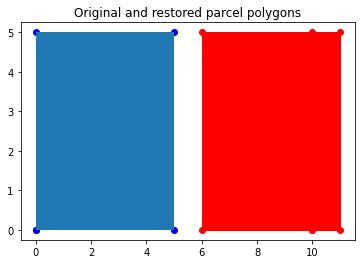

In [4]:
# for display purposes, let's move the 
# restored parcel over to the right
# so we can see the original and 
# new polygons side-by-side
restored_parcel_poly = restored_parcel_poly.transform(6, 0)

# plot the old and new parcels with
# their vertices
ax = parcel_poly.plot()
for point in parcel_poly.points:
    point.plot(ax=ax, color='blue')

restored_parcel_poly.plot(ax=ax, color='red')
for point in restored_parcel_poly.points:
    point.plot(ax=ax, color='red')

ax.set_title('Original and restored parcel polygons')

As you can see in the image above, two vertices were added to the parcel polygon as a result of the sliver elimination process.

## The Solution (maybe): Smarter Sublot Cuts

The original sliver elimination logic took a two-step approach to dealing with slivers, specifically:

* Create the sublots using the input and overlay geometries (and allow slivers to be created)
* Search through the resulting sublot polygons, find the slivers in the outputs, and merge them into their neighbors

To solve the issues caused by merging polygons together we'll attempt to detect slivers _during the sublot cutting process._ Rather than merging slivers into their neighbors, we'll simply ignore the split polygons if the split results in a sliver and restore the original unsplit polygon (with no artifact vertices).

Total slivers detected: 1


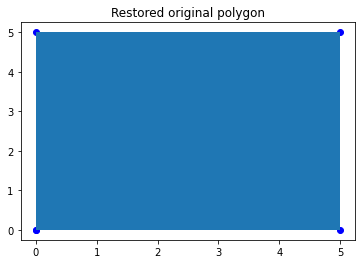

In [5]:
# as before, we'll divide the parcel poly into sublots using the overlay
sliver_poly = parcel_poly.intersection(overlay_poly)
sublot_poly = parcel_poly.difference(overlay_poly)

# however, rather than allowing slivers to be created and then cleaned up later,
# we will immediately check to see a sliver was created while it is still
# possible to restore the original polygon

# to find sliver polygons, make a list of the outputs that qualify as slivers
# if the length of the list is > 0
sliver_list = list(filter(lambda x: x.is_sliver(threshold=2), [sliver_poly, sublot_poly]))
print(f'Total slivers detected: {len(sliver_list)}')
if len(sliver_list) > 0:
    ax = parcel_poly.plot()
    ax.set_title('Restored original polygon')
    for point in parcel_poly.points:
        point.plot(ax=ax, color='blue')
else:
    ax = sublot_poly.plot()
    sliver_poly.plot(ax=ax, color='red')
    ax.set_title('Using New Sublot Polygons')
    for point in sublot_poly.points:
        point.plot(ax=ax, color='blue')
    for point in sliver_poly.points:
        point.plot(ax=ax, color='red')



Total slivers detected: 0


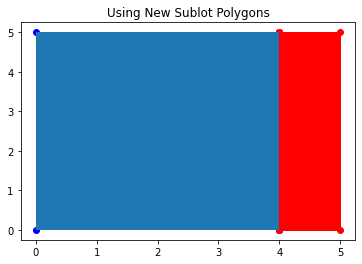

In [6]:
# for the sake of example, let's run the
# same logic with a reduced sliver threshold

sliver_list = list(filter(lambda x: x.is_sliver(threshold=0.5), [sliver_poly, sublot_poly]))
print(f'Total slivers detected: {len(sliver_list)}')
if len(sliver_list) > 0:
    ax = parcel_poly.plot()
    ax.set_title('Restored original polygon')
    for point in parcel_poly.points:
        point.plot(ax=ax, color='blue')
else:
    ax = sublot_poly.plot()
    sliver_poly.plot(ax=ax, color='red')
    ax.set_title('Using New Sublot Polygons')
    for point in sublot_poly.points:
        point.plot(ax=ax, color='blue')
    for point in sliver_poly.points:
        point.plot(ax=ax, color='red')


## A New Issue: Topology

Generally speaking, the logic above is superior to the previous sliver elimination logic in terms of restoring polygons to their original form when a sliver is detected. However, in more complex cases issues can arise. The example below demonstrates a more complex overlay situation where the new sliver elimination logic can introduce new topology issues.

Text(0.5, 1.0, 'Parcel and overlay geometries')

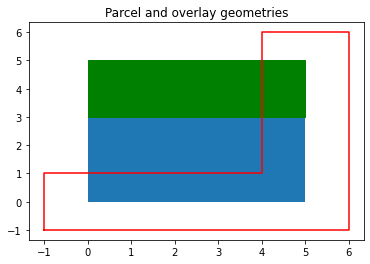

In [7]:
# now let's create a more complex situation involving two parcel polygons

parcel_points = [
    {'x': 0, 'y': 0},
    {'x': 5, 'y': 0},
    {'x': 5, 'y': 3},
    {'x': 0, 'y': 3},
    {'x': 0, 'y': 0},
]
parcel_poly_1 = Polygon(parcel_points, 2263)

parcel_points = [
    {'x': 0, 'y': 3},
    {'x': 5, 'y': 3},
    {'x': 5, 'y': 5},
    {'x': 0, 'y': 5},
    {'x': 0, 'y': 3},
]
parcel_poly_2 = Polygon(parcel_points, 2263)

# Create a tricker overlay geometry
overlay_points = [
    {'x': -1, 'y': -1},
    {'x': 6, 'y': -1},
    {'x': 6, 'y': 6},
    {'x': 4, 'y': 6},
    {'x': 4, 'y': 1},
    {'x': -1, 'y': 1},
    {'x': -1, 'y': -1},
]
overlay_poly = Polygon(overlay_points, 2263)

# plot our new inputs
ax = parcel_poly_1.plot()
parcel_poly_2.plot(ax=ax, color='green')
overlay_boundary = overlay_poly.boundary()
overlay_boundary.plot(ax=ax, color='red')
ax.set_title('Parcel and overlay geometries')

Text(0.5, 1.0, 'Sublot and Sliver Polygons')

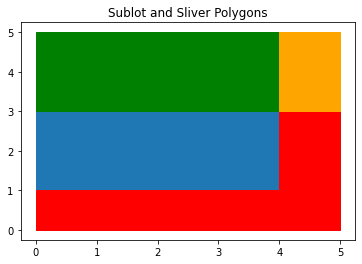

In [8]:
# as before, we'll divide the parcel polys into sublots using the overlay
sliver_poly_1 = parcel_poly_1.intersection(overlay_poly)
sublot_poly_1 = parcel_poly_1.difference(overlay_poly)
sliver_poly_2 = parcel_poly_2.intersection(overlay_poly)
sublot_poly_2 = parcel_poly_2.difference(overlay_poly)

# plot the sublots
ax = sublot_poly_1.plot()
sliver_poly_1.plot(ax=ax, color='red')
sublot_poly_2.plot(ax=ax, color='green')
sliver_poly_2.plot(ax=ax, color='orange')
ax.set_title('Sublot and Sliver Polygons')

Total slivers detected: 0
Total slivers detected: 1


<AxesSubplot:title={'center':'Sliver Eliminated Geometries'}>

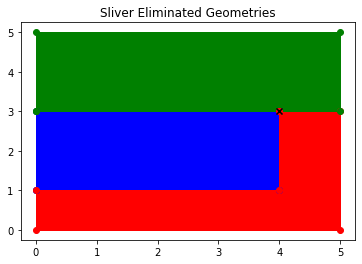

In [11]:
# now, let's apply the new sliver logic to reveal the new topology issue
final_outputs = []

sliver_list = list(filter(lambda x: x.is_sliver(threshold=1.5), [sliver_poly_1, sublot_poly_1]))
print(f'Total slivers detected: {len(sliver_list)}')
if len(sliver_list) > 0:
    final_outputs.append(parcel_poly_1)
else:
    final_outputs.append(sublot_poly_1)
    final_outputs.append(sliver_poly_1)

sliver_list = list(filter(lambda x: x.is_sliver(threshold=1.5), [sliver_poly_2, sublot_poly_2]))
print(f'Total slivers detected: {len(sliver_list)}')
if len(sliver_list) > 0:
    final_outputs.append(parcel_poly_2)
else:
    final_outputs.append(sublot_poly_2)
    final_outputs.append(sliver_poly_2)
    
# plot the outputs
ax = None
for poly in final_outputs:
    color = 'blue' if poly.equals(parcel_poly_1) or poly.equals(sublot_poly_1) else \
            'red' if poly.equals(sliver_poly_1) else \
            'orange' if poly.equals(sliver_poly_2) else \
            'green'
    if not ax:
        ax = poly.plot(color=color)
    else:
        poly.plot(ax=ax, color=color)
    for point in poly.points:
        point.plot(ax=ax, color=color, zorder=3)
ax.set_title('Sliver Eliminated Geometries')

# put a marker on the bad vertex
bad_vertex = Point({'x': 4, 'y': 3}, 2263)
bad_vertex.plot(ax=ax, color='black', marker='x', zorder=4)

As you can see in the image above, a vertex is created when the lower polygon is subdivided into sublots that is not present in the sliver-corrected polygon ajacent to it.